In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
os.chdir(os.getenv("PROJECT_ROOT"))

# learn

In [2]:
import numpy as np
from scipy import linalg

import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess as sm_lowess


In [3]:
def lowess(x, y, f=2./3., iter=3):
    """
    Basic LOWESS smoother with uncertainty.
    Parameters:
        x : x-values
        y : y-values
        f : smoother span (proportion of data used for each fit)
        iter : number of robustness iterations
    Returns:
        smoothed y-values
    """
    n = len(x)
    r = int(np.ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    
    yest = np.zeros(n)
    delta = np.ones(n)
    
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([
                [np.sum(weights), np.sum(weights * x)],
                [np.sum(weights * x), np.sum(weights * x * x)]
            ])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]
        
        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2
    
    return yest

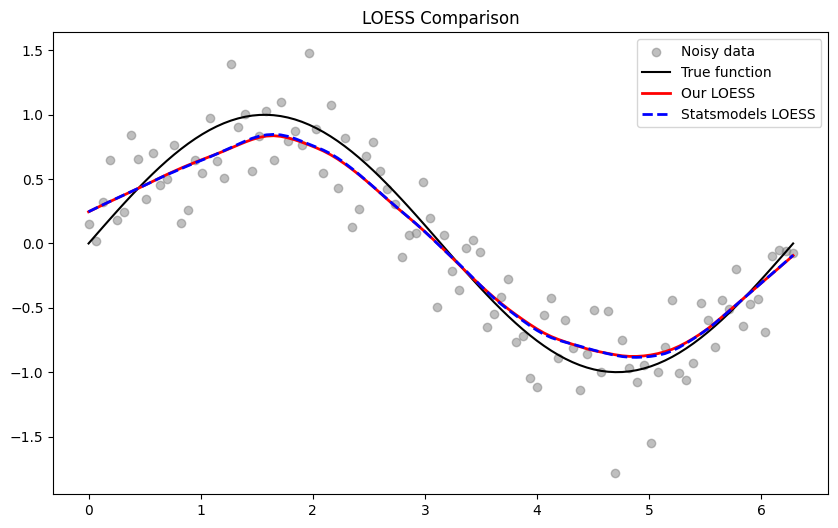

Our implementation MSE: 0.0141
Statsmodels MSE: 0.0134


In [4]:
# Generate sample data
np.random.seed(42)
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x) + 0.3 * np.random.normal(size=100)

# Our implementation
our_loess = lowess(x, y, f=0.25)

# Statsmodels implementation
sm_loess = sm_lowess(y, x, frac=0.25, it=3, return_sorted=False)

# Plot comparison
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='gray', alpha=0.5, label='Noisy data')
plt.plot(x, np.sin(x), 'k-', label='True function')
plt.plot(x, our_loess, 'r-', linewidth=2, label='Our LOESS')
plt.plot(x, sm_loess, 'b--', linewidth=2, label='Statsmodels LOESS')
plt.legend()
plt.title('LOESS Comparison')
plt.show()

# Calculate MSE
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

true_values = np.sin(x)
our_mse = mse(true_values, our_loess)
sm_mse = mse(true_values, sm_loess)

print(f"Our implementation MSE: {our_mse:.4f}")
print(f"Statsmodels MSE: {sm_mse:.4f}")

In [5]:
import numpy as np
from scipy import linalg
from scipy.interpolate import interp1d
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt

def tricubic(x):
    """Tricubic weight function"""
    return np.where(np.abs(x) < 1, (1 - np.abs(x)**3)**3, 0)

def loess_scratch(x, y, bandwidth=0.25, degree=1, robust_iters=0):
    """
    LOESS implementation from scratch
    
    Parameters:
    - x, y: data points
    - bandwidth: fraction of data to use in each local regression
    - degree: degree of polynomial (1 or 2)
    - robust_iters: number of robustness iterations (0 for no robustness)
    
    Returns:
    - smoothed y values
    """
    n = len(x)
    y_smooth = np.zeros(n)
    weights = np.ones(n)
    
    for _ in range(robust_iters + 1):
        for i in range(n):
            # Calculate distances from current point
            dist = np.abs(x - x[i])
            
            # Determine bandwidth for this point
            h = np.sort(dist)[int(bandwidth * n)]
            
            # Calculate weights
            w = weights * tricubic(dist / h)
            
            # Filter points with non-zero weights
            mask = w > 0
            x_local = x[mask]
            y_local = y[mask]
            w_local = w[mask]
            
            # Weighted least squares
            if degree == 1:
                X = np.column_stack([np.ones_like(x_local), x_local])
            elif degree == 2:
                X = np.column_stack([np.ones_like(x_local), x_local, x_local**2])
            
            X_weighted = X * np.sqrt(w_local)[:, np.newaxis]
            y_weighted = y_local * np.sqrt(w_local)
            
            try:
                beta = linalg.lstsq(X_weighted, y_weighted)[0]
                if degree == 1:
                    y_smooth[i] = beta[0] + beta[1] * x[i]
                else:
                    y_smooth[i] = beta[0] + beta[1] * x[i] + beta[2] * x[i]**2
            except:
                # Fallback to simple average if regression fails
                y_smooth[i] = np.average(y_local, weights=w_local)
        
        # Update robustness weights
        if _ < robust_iters:
            residuals = y - y_smooth
            median_abs_residual = np.median(np.abs(residuals))
            robustness_weights = np.minimum(1, 6 * np.abs(residuals) / (6 * median_abs_residual))
            weights = robustness_weights
    
    return y_smooth

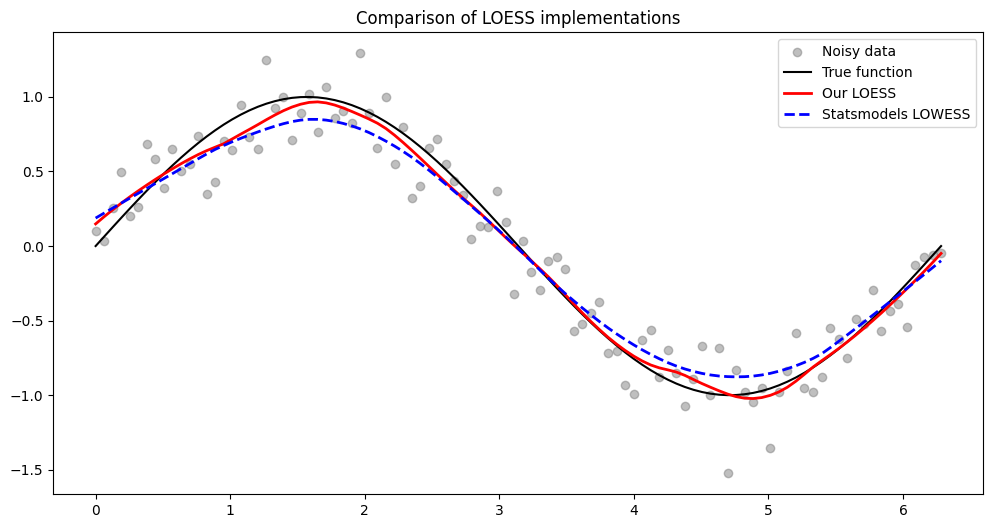

MSE Our Implementation: 0.003593
MSE Statsmodels: 0.010461


In [6]:
def compare_loess_implementations():
    # Generate sample data
    np.random.seed(42)
    x = np.linspace(0, 2*np.pi, 100)
    y = np.sin(x) + np.random.normal(0, 0.2, len(x))
    
    # Our implementation
    y_scratch = loess_scratch(x, y, bandwidth=0.3, degree=2, robust_iters=3)
    
    # Statsmodels implementation
    sm_result = lowess(y, x, frac=0.3, it=3, delta=0.01)
    y_sm = sm_result[:, 1]
    
    # Plot comparison
    plt.figure(figsize=(12, 6))
    plt.scatter(x, y, color='gray', alpha=0.5, label='Noisy data')
    plt.plot(x, np.sin(x), 'k-', label='True function')
    plt.plot(x, y_scratch, 'r-', linewidth=2, label='Our LOESS')
    plt.plot(x, y_sm, 'b--', linewidth=2, label='Statsmodels LOWESS')
    plt.legend()
    plt.title('Comparison of LOESS implementations')
    plt.show()
    
    # Calculate MSE
    true_values = np.sin(x)
    mse_scratch = np.mean((y_scratch - true_values)**2)
    mse_sm = np.mean((y_sm - true_values)**2)
    
    print(f"MSE Our Implementation: {mse_scratch:.6f}")
    print(f"MSE Statsmodels: {mse_sm:.6f}")

compare_loess_implementations()

In [7]:
# def stl_decomposition(y, period, loess_func, trend_bandwidth=0.75, seasonal_bandwidth=0.75, robust_iters=3):
#     """
#     STL-like decomposition using LOESS
    
#     Parameters:
#     - y: time series data
#     - period: seasonal period
#     - loess_func: LOESS function to use (our implementation or statsmodels)
#     - trend_bandwidth: bandwidth for trend smoothing
#     - seasonal_bandwidth: bandwidth for seasonal smoothing
#     - robust_iters: number of robustness iterations
    
#     Returns:
#     - trend, seasonal, remainder components
#     """
#     n = len(y)
#     x = np.arange(n)
    
#     # Step 1: Detrending
#     trend = loess_func(x, y, bandwidth=trend_bandwidth, degree=1, robust_iters=robust_iters)
#     detrended = y - trend
    
#     # Step 2: Seasonal smoothing
#     # Create periodic version of the data
#     seasonal = np.zeros(n)
#     for i in range(period):
#         # Get all points at this seasonal position
#         indices = np.arange(i, n, period)
#         if len(indices) == 0:
#             continue
        
#         # Smooth the seasonal component at these points
#         seasonal_i = loess_func(
#             indices, 
#             detrended[indices], 
#             bandwidth=seasonal_bandwidth, 
#             degree=1, 
#             robust_iters=robust_iters
#         )
        
#         # Center the seasonal component
#         seasonal_i -= np.mean(seasonal_i)
#         seasonal[indices] = seasonal_i
    
#     # Step 3: Deseasonalizing
#     deseasonalized = y - seasonal
    
#     # Step 4: Trend smoothing on deseasonalized data
#     trend = loess_func(x, deseasonalized, bandwidth=trend_bandwidth, degree=1, robust_iters=robust_iters)
    
#     # Step 5: Calculate remainder
#     remainder = y - trend - seasonal
    
#     return trend, seasonal, remainder

# def demonstrate_stl():
#     # Create synthetic seasonal data
#     np.random.seed(42)
#     n = 200
#     period = 24
#     x = np.arange(n)
#     trend = 0.001 * (x - 100)**2
#     seasonal = 2 * np.sin(2 * np.pi * x / period)
#     noise = np.random.normal(0, 0.5, n)
#     y = trend + seasonal + noise
    
#     # Perform decomposition with our LOESS
#     trend_ours, seasonal_ours, remainder_ours = stl_decomposition(
#         y, period, loess_scratch, trend_bandwidth=0.3, seasonal_bandwidth=0.3
#     )
    
#     # Perform decomposition with statsmodels LOWESS
#     def sm_loess(x, y, bandwidth, degree, robust_iters):
#         # Wrapper for statsmodels lowess
#         result = lowess(y, x, frac=bandwidth, it=robust_iters, delta=0.01)
#         return result[:, 1]
    
#     trend_sm, seasonal_sm, remainder_sm = stl_decomposition(
#         y, period, sm_loess, trend_bandwidth=0.3, seasonal_bandwidth=0.3
#     )
    
#     # Plot results
#     fig, axes = plt.subplots(4, 2, figsize=(14, 12))
    
#     titles = ['Original', 'Trend', 'Seasonal', 'Remainder']
#     for i, (our_comp, sm_comp, title) in enumerate(zip(
#         [y, trend_ours, seasonal_ours, remainder_ours],
#         [y, trend_sm, seasonal_sm, remainder_sm],
#         titles
#     )):
#         axes[i, 0].plot(our_comp)
#         axes[i, 0].set_title(f"Our Implementation - {title}")
#         axes[i, 1].plot(sm_comp)
#         axes[i, 1].set_title(f"Statsmodels - {title}")
    
#     plt.tight_layout()
#     plt.show()

# demonstrate_stl()

In [8]:
class LoessConfig:
    """Configuration for LOESS smoothing"""
    def __init__(self):
        # Trend estimation parameters
        self.trend_bandwidth = 0.25  # Fraction of data for local regression
        self.trend_degree = 1        # Polynomial degree (1=linear, 2=quadratic)
        self.trend_robust_iters = 3  # Robustness iterations
        
        # Seasonal estimation parameters
        self.seasonal_bandwidth = 0.25
        self.seasonal_degree = 1
        self.seasonal_robust_iters = 3
        
        # Low-level LOESS parameters
        self.delta = 0.01 
        # Fraction of range for skipping calculations


import numpy as np
from scipy import linalg
from typing import Callable

class LoessSmoother:
    def __init__(self, config: LoessConfig = None):
        self.config = config if config else LoessConfig()
    
    @staticmethod
    def _tricubic(x: np.ndarray) -> np.ndarray:
        """Tricubic weight function"""
        return np.where(np.abs(x) < 1, (1 - np.abs(x)**3)**3, 0)
    
    @staticmethod
    def _calculate_robustness_weights(residuals: np.ndarray) -> np.ndarray:
        """Calculate robustness weights from residuals"""
        median_abs_residual = np.median(np.abs(residuals))
        return np.minimum(1, 6 * np.abs(residuals) / (6 * median_abs_residual))
    
    def smooth(self, 
               x: np.ndarray, 
               y: np.ndarray, 
               bandwidth: float = None,
               degree: int = None,
               robust_iters: int = None) -> np.ndarray:
        """
        Perform LOESS smoothing
        
        Args:
            x: Independent variable (must be sorted)
            y: Dependent variable
            bandwidth: Fraction of data to use in each local regression
            degree: Polynomial degree (1 or 2)
            robust_iters: Number of robustness iterations
            
        Returns:
            Smoothed y values
        """
        # Use config values if parameters not provided
        bandwidth = bandwidth if bandwidth is not None else self.config.trend_bandwidth
        degree = degree if degree is not None else self.config.trend_degree
        robust_iters = robust_iters if robust_iters is not None else self.config.trend_robust_iters
        
        n = len(x)
        y_smooth = np.zeros(n)
        weights = np.ones(n)
        
        for _ in range(robust_iters + 1):
            for i in range(n):
                # Calculate distances and bandwidth
                dist = np.abs(x - x[i])
                h = np.sort(dist)[int(bandwidth * n)]
                
                # Calculate weights
                w = weights * self._tricubic(dist / h)
                mask = w > 0
                if not np.any(mask):
                    y_smooth[i] = np.mean(y)
                    continue
                
                # Prepare weighted regression
                x_local, y_local, w_local = x[mask], y[mask], w[mask]
                
                if degree == 1:
                    X = np.column_stack([np.ones_like(x_local), x_local])
                elif degree == 2:
                    X = np.column_stack([np.ones_like(x_local), x_local, x_local**2])
                
                # Solve weighted least squares
                X_weighted = X * np.sqrt(w_local)[:, np.newaxis]
                y_weighted = y_local * np.sqrt(w_local)
                
                try:
                    beta = linalg.lstsq(X_weighted, y_weighted)[0]
                    if degree == 1:
                        y_smooth[i] = beta[0] + beta[1] * x[i]
                    else:
                        y_smooth[i] = beta[0] + beta[1] * x[i] + beta[2] * x[i]**2
                except:
                    y_smooth[i] = np.average(y_local, weights=w_local)
            
            # Update robustness weights if needed
            if _ < robust_iters:
                residuals = y - y_smooth
                weights = self._calculate_robustness_weights(residuals)
        
        return y_smooth
    
class STLDecomposer:
    def __init__(self, period: int, config: LoessConfig = None):
        self.period = period
        self.config = config if config else LoessConfig()
        self.loess = LoessSmoother(config)
    
    def _extract_seasonal_component(self, detrended: np.ndarray) -> np.ndarray:
        """Improved seasonal component extraction"""
        n = len(detrended)
        seasonal = np.zeros(n)
        
        # First pass: rough seasonal estimation
        for i in range(self.period):
            indices = np.arange(i, n, self.period)
            if len(indices) < 2:  
                continue
                
            seasonal_i = self.loess.smooth(
                indices,
                detrended[indices],
                bandwidth=self.config.seasonal_bandwidth,
                degree=1,  # Always use linear for seasonal
                robust_iters=self.config.seasonal_robust_iters
            )
            seasonal[indices] = seasonal_i
        
        # Second pass: smooth the seasonal component
        seasonal = self.loess.smooth(
            np.arange(n),
            seasonal,
            bandwidth=min(0.3, 3/self.period),  # Adaptive bandwidth
            degree=1,
            robust_iters=self.config.seasonal_robust_iters
        )
        
        # Center and return
        return seasonal - np.mean(seasonal)
    
    def decompose(self, y: np.ndarray) -> dict:
        """Improved decomposition with better component separation"""
        n = len(y)
        x = np.arange(n)
        
        # Step 1: Robust trend estimation (very smooth)
        trend = self.loess.smooth(
            x, y,
            bandwidth=max(0.3, self.config.trend_bandwidth),
            degree=self.config.trend_degree,
            robust_iters=self.config.trend_robust_iters
        )
        
        # Step 2: Detrend and extract seasonality
        detrended = y - trend
        seasonal = self._extract_seasonal_component(detrended)
        
        # Step 3: Robust trend re-estimation
        deseasonalized = y - seasonal
        trend = self.loess.smooth(
            x, deseasonalized,
            bandwidth=self.config.trend_bandwidth,
            degree=self.config.trend_degree,
            robust_iters=self.config.trend_robust_iters
        )
        
        # Step 4: Final residual calculation
        resid = y - trend - seasonal
        
        # Post-processing: ensure residuals don't contain seasonality
        residual_seasonality = self._extract_seasonal_component(resid)
        seasonal += residual_seasonality
        resid -= residual_seasonality
        
        return {
            'trend': trend,
            'seasonal': seasonal,
            'resid': resid,
            'deseasonalized': deseasonalized
        }

/tmp/ipykernel_163889/1117006649.py:36: RuntimeWarning: divide by zero encountered in divide
  return np.minimum(1, 6 * np.abs(residuals) / (6 * median_abs_residual))
/tmp/ipykernel_163889/1117006649.py:36: RuntimeWarning: invalid value encountered in divide
  return np.minimum(1, 6 * np.abs(residuals) / (6 * median_abs_residual))


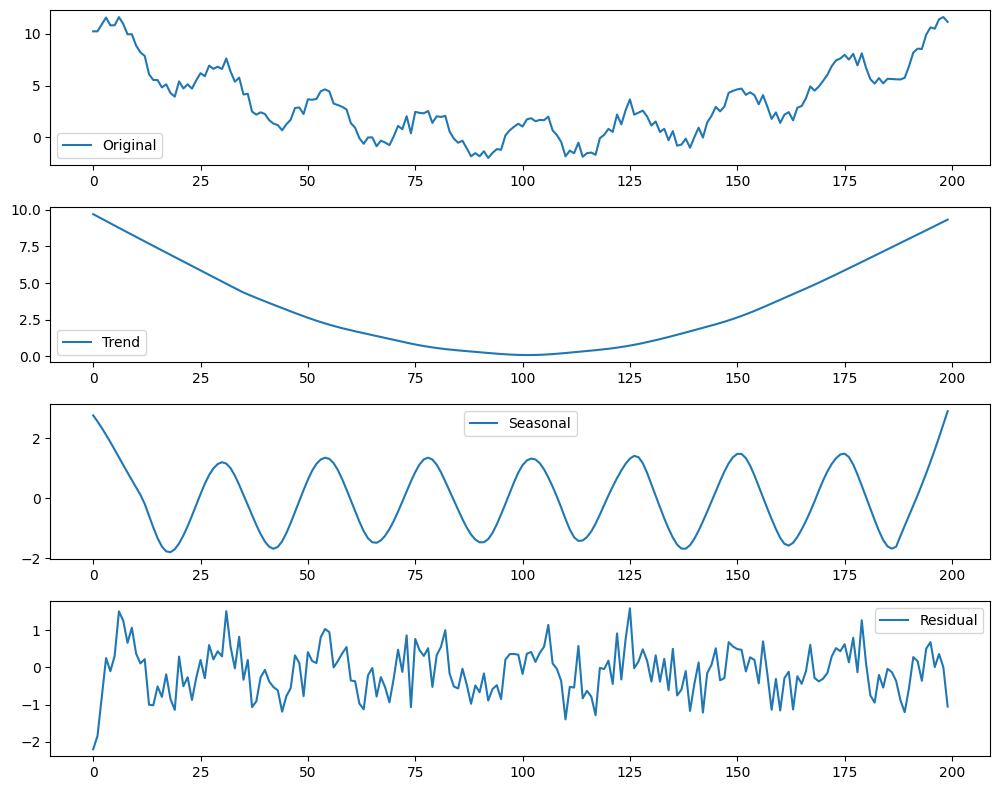

In [9]:
import matplotlib.pyplot as plt

def create_seasonal_data(n=200, period=24, noise_scale=0.5):
    """Generate synthetic seasonal data"""
    np.random.seed(42)
    x = np.arange(n)
    trend = 0.001 * (x - 100)**2
    seasonal = 2 * np.sin(2 * np.pi * x / period)
    noise = np.random.normal(0, noise_scale, n)
    return x, trend + seasonal + noise

def demonstrate_decomposition():
    # Create configuration with optimal parameters
    config = LoessConfig()
    config.trend_bandwidth = 0.35  # Smoother trend
    config.seasonal_bandwidth = 0.2  # Tighter seasonality
    config.trend_robust_iters = 5
    config.seasonal_robust_iters = 5
    config.trend_degree = 1 
    
    # Generate data
    x, y = create_seasonal_data()
    
    # Perform decomposition
    decomposer = STLDecomposer(period=24, config=config)
    components = decomposer.decompose(y)
    
    # Plot results
    fig, axes = plt.subplots(4, 1, figsize=(10, 8))
    
    axes[0].plot(y, label='Original')
    axes[0].legend()
    
    axes[1].plot(components['trend'], label='Trend')
    axes[1].legend()
    
    axes[2].plot(components['seasonal'], label='Seasonal')
    axes[2].legend()
    
    axes[3].plot(components['resid'], label='Residual')
    axes[3].legend()
    
    plt.tight_layout()
    plt.show()
    
    return components

# Run the demonstration
components = demonstrate_decomposition()

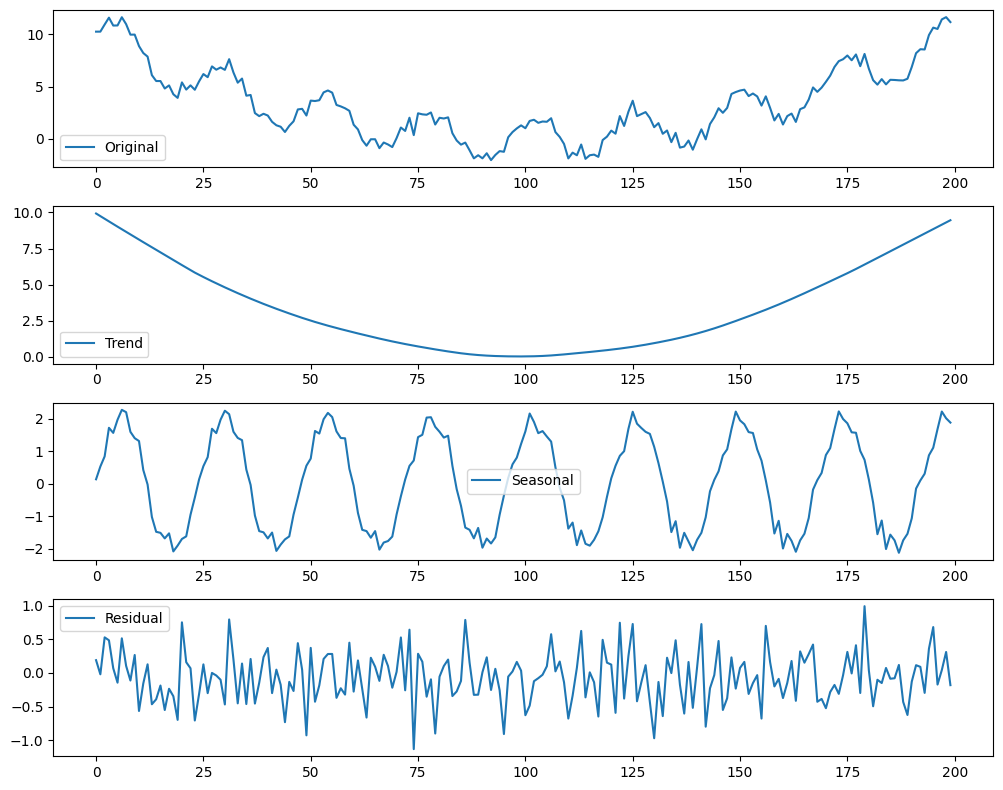

In [10]:
from statsmodels.tsa.seasonal import STL
import pandas as pd

x, y = create_seasonal_data()

stl = STL(y, period=24, seasonal_deg=0) 
result = stl.fit()
# Извлечение компонентов
components = {
    'trend': result.trend,
    'seasonal': result.seasonal, 
    'resid': result.resid
    }

# Plot results
fig, axes = plt.subplots(4, 1, figsize=(10, 8))

axes[0].plot(y, label='Original')
axes[0].legend()

axes[1].plot(components['trend'], label='Trend')
axes[1].legend()

axes[2].plot(components['seasonal'], label='Seasonal')
axes[2].legend()

axes[3].plot(components['resid'], label='Residual')
axes[3].legend()

plt.tight_layout()
plt.show()

/home/ilia_linux/patrec_time_series/.basic_venv/lib/python3.12/site-packages/statsmodels/tsa/stl/mstl.py:218: UserWarning: A period(s) is larger than half the length of time series. Removing these period(s).
  warnings.warn(


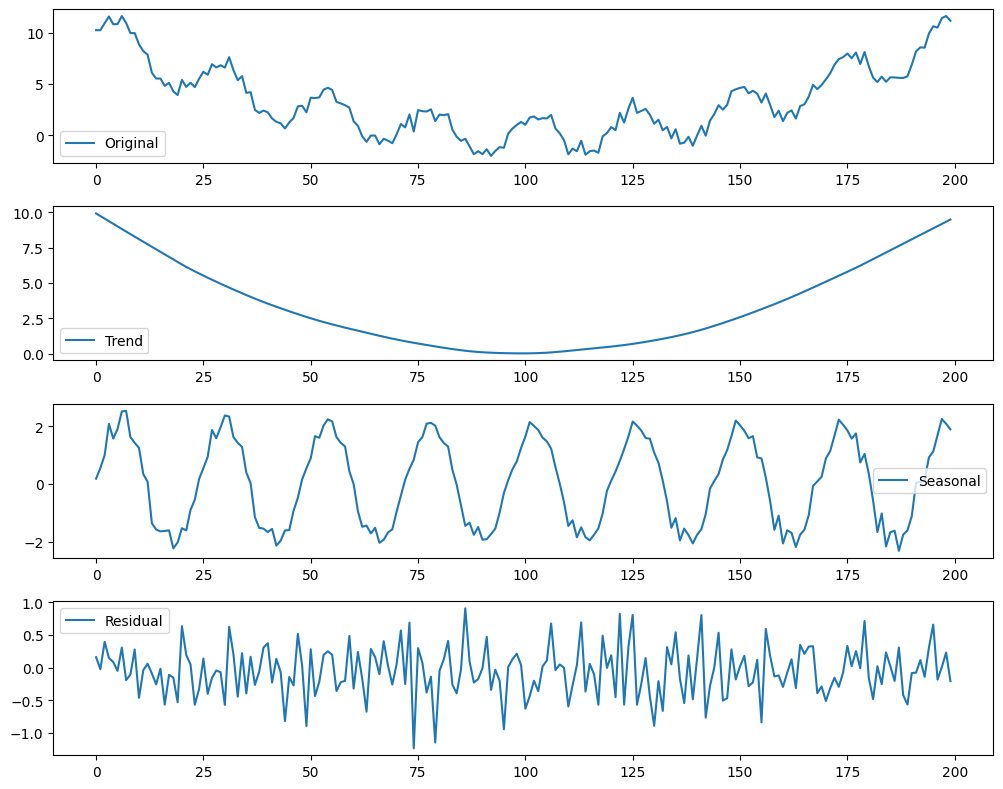

In [11]:
from statsmodels.tsa.seasonal import MSTL

x, y = create_seasonal_data()

stl = MSTL(y, periods=(24, 24*10)) 
result = stl.fit()
# Извлечение компонентов
components = {
    'trend': result.trend,
    'seasonal': result.seasonal, 
    'resid': result.resid
    }

# Plot results
fig, axes = plt.subplots(4, 1, figsize=(10, 8))

axes[0].plot(y, label='Original')
axes[0].legend()

axes[1].plot(components['trend'], label='Trend')
axes[1].legend()

axes[2].plot(components['seasonal'], label='Seasonal')
axes[2].legend()

axes[3].plot(components['resid'], label='Residual')
axes[3].legend()

plt.tight_layout()
plt.show()

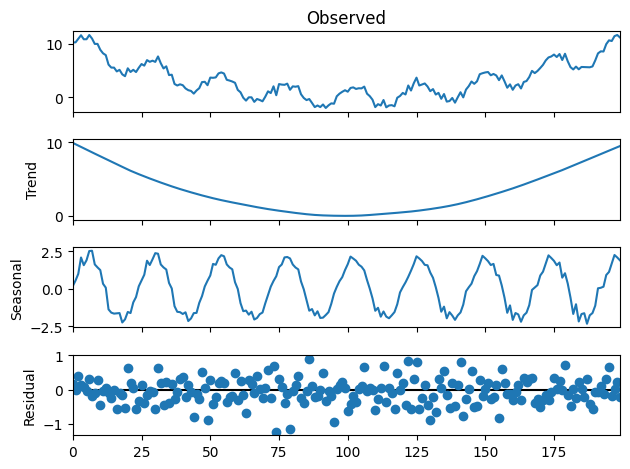

In [12]:
result.plot()
plt.tight_layout()
plt.show()

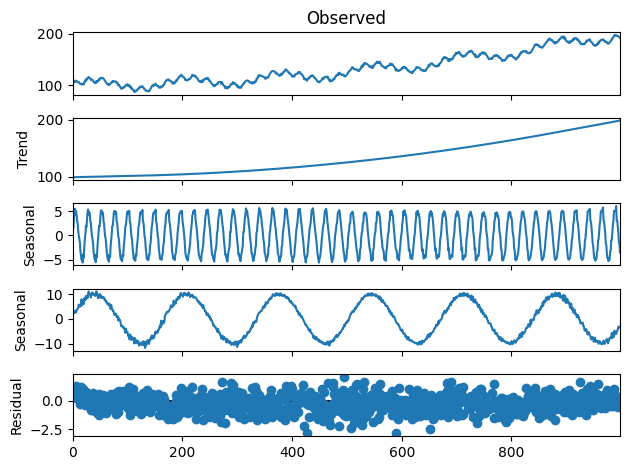

In [13]:
pd.plotting.register_matplotlib_converters()
np.random.seed(0)
t = np.arange(1, 1000)
trend = 0.0001 * t ** 2 + 100
daily_seasonality = 5 * np.sin(2 * np.pi * t / 24)
weekly_seasonality = 10 * np.sin(2 * np.pi * t / (24 * 7))
noise = np.random.randn(len(t))
y = trend + daily_seasonality + weekly_seasonality + noise
index = pd.date_range(start='2000-01-01', periods=len(t), freq='h')
# data = pd.DataFrame(data=y, index=index)

res = MSTL(y, periods=(24, 24*7)).fit()
res.plot()
plt.tight_layout()
plt.show()

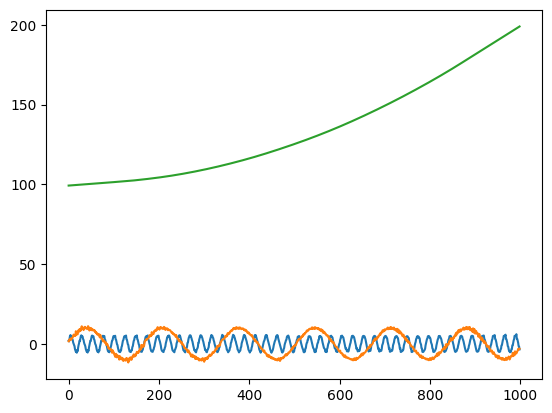

In [14]:
plt.plot(res.seasonal[:,0])
plt.plot(res.seasonal[:,1])
plt.plot(res.trend)

In [15]:
NAME = 'MelbournePedestrian'
# NAME = 'DucksAndGeese'
X_samp2 = np.load(f'data/sub_UCR_bench/{NAME}/sample_2/X_train.npy')
X_samp2

array([[[  46.,   38.,   13., ...,  400.,  291.,  128.]],

       [[ 123.,   79.,   47., ...,  469.,  271.,  183.]],

       [[ 855.,  863.,  446., ...,  503.,  386.,  253.]],

       ...,

       [[ 731.,  376.,  213., ...,  908.,  447.,  225.]],

       [[ 236.,  108.,   48., ..., 2169., 1768., 1229.]],

       [[ 154.,   67.,   32., ...,  794.,  522.,  282.]]])

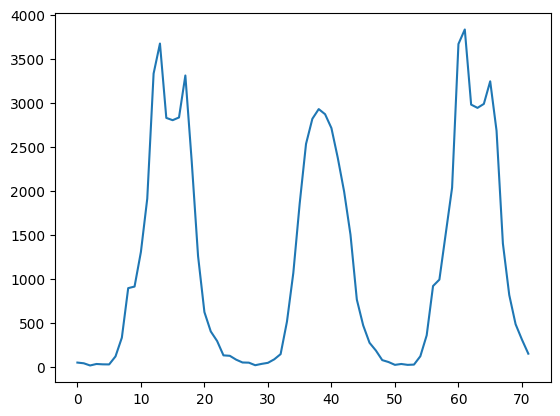

In [16]:
y = np.concatenate([X_samp2[0, 0, :], X_samp2[1, 0, :], X_samp2[4, 0, :]])
# y = X_samp2[0, 0, 50000:50500].copy()
plt.plot(y)

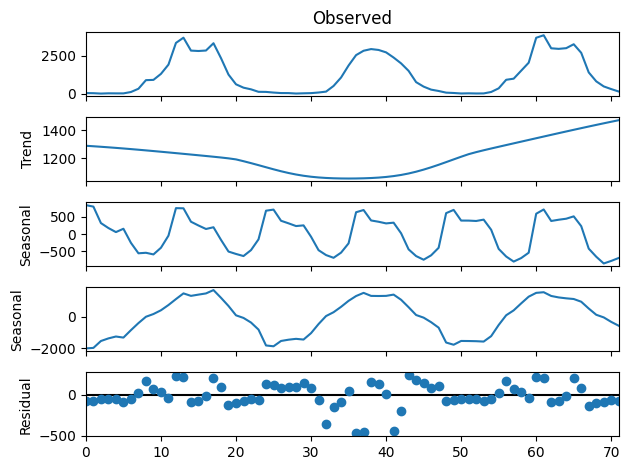

In [17]:
# res = MSTL(y, periods=(4, 8, 12, 16, 24, 48, 64)).fit()
res = MSTL(y, periods=(12,24)).fit()
res.plot()
plt.tight_layout()
plt.show()

# Experiment 1

Просто использую разложение рядов для выделения компонент


- config файл
- данные входные изображения
- результаты после использования алгоритмов и все шаги. Надо сохранять все в общем порядке, чтобы не приходилось что-то сложное писать. Условно всю pics надо скачать, а отдельные детали можно смотреть на всяких картах и прочее


mlflow server --backend-store-uri ".backend" --default-artifact-root ".artifacts" --host localhost --port 5000

In [18]:
from patrec.utils import plot_series

In [19]:
from typing import Literal
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import STL, MSTL

@dataclass
class STL_model_config:
    period: int = 7
    seasonal:int = 7
    trend_deg: Literal[1, 2] = 1
    seasonal_deg: Literal[1, 2] = 1

@dataclass
class Experiment1_config:
    data_dict: dict
    params: STL_model_config
    save_path: str = '.temp/Stl_decomp_exp1/'
    

def load_data(dt_name:str, sample_num:Literal[0,1,2]):
    """
    Dataset loading
    """
    sample_num = str(sample_num)
    datasets = {
        'HAR': Path(f'data/HAR_bench/sample_{sample_num}'),
        'AbnormalHeartbeat': Path(f'data/sub_UCR_bench/AbnormalHeartbeat/sample_{sample_num}'),
        'DucksAndGeese': Path(f'data/sub_UCR_bench/DucksAndGeese/sample_{sample_num}'),
        'MelbournePedestrian': Path(f'data/sub_UCR_bench/MelbournePedestrian/sample_{sample_num}'), 
        'Synth': Path()
    }
    
    X_train = np.asarray([np.transpose(row) for row in np.load(Path(datasets.get(dt_name))/'X_train.npy')]) if dt_name == 'HAR' else np.load(Path(datasets.get(dt_name))/'X_train.npy')
    X_test = np.asarray([np.transpose(row) for row in np.load(Path(datasets.get(dt_name))/'X_test.npy')]) if dt_name == 'HAR' else np.load(Path(datasets.get(dt_name))/'X_test.npy')
    y_train = np.load(Path(datasets.get(dt_name))/'y_train.npy')
    y_test = np.load(Path(datasets.get(dt_name))/'y_test.npy')
    
    return X_train, X_test, y_train, y_test
    
def experiment1(config:Experiment1_config):
    """
    В ходе эксперимента просто выделяем компоненты из отдельных рядов
    
    """
    # load data
    X_train, _, y_train, _ = load_data(**config.data_dict)
    # results
    result_json = {}
    # init model
    
    # estimate result and save to result_json 
    for idx, (X, y) in enumerate(zip(X_train, y_train)):
        result_json[idx] = {
            'trend': [],
            'seasonal': [],
            'resid': []
        }
        
        if X.shape[1] > 1:
            for dim, x_dim in enumerate(X):
                result = STL(endog=x_dim, **config.params.__dict__).fit()
                result_json[idx]['trend'].append(result.trend.tolist())
                result_json[idx]['seasonal'].append(result.seasonal.tolist())
                result_json[idx]['resid'].append(result.resid.tolist())
                
        else:
            result = STL(endog=X, **config.params.__dict__).fit()
            result_json[idx] = {
                'trend':result.trend.tolist(),
                'seasonal':result.seasonal.tolist(),
                'resid':result.resid.tolist()
            }
    
    return result_json

In [20]:
# mlflow server --backend-store-uri ".backend" --default-artifact-root ".artifacts" --host localhost --port 5000

from patrec.utils.mlflow_exp import MLflowExperimentLogger
import mlflow

# Устанавливаем соединение с MLflow сервером
mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("STL_exp")

# Загружаем общий файл параметров
params_file = save_path / "params/result_params.yaml"
params = load_config_file(params_file)

with mlflow.start_run():

    # --- 1. Логируем общие параметры ---
    def log_nested_params(d, prefix=""):
        for key, value in d.items():
            if isinstance(value, dict):
                log_nested_params(value, prefix=f"{prefix}{key}.")
            else:
                try:
                    mlflow.log_param(f"{prefix}{key}", value)
                except:
                    mlflow.log_param(f"{prefix}{key}", str(value))

    log_nested_params(params, prefix="params.")

    # --- 2. Логируем графики и метрики ---
    est_params_paths = sorted(save_path.glob("est_params/*.yaml"))
    metrics_path = save_path / "result_metrics.yaml"

    metric_means = {}

    # Читаем метрики
    metrics = {k:ast.literal_eval(v) for k,v in load_config_file(metrics_path).items()}

    # Логируем средние метрики
    for comp_name, values in metrics.items():
        mean_value = sum(values) / len(values) if values else float('nan')
        mlflow.log_metric(f"mean_{comp_name}_rmse", mean_value)
        metric_means[comp_name] = mean_value

    # --- 3. Логируем графики ---
    mlflow.log_artifacts(save_path / "pics", artifact_path="pics")

    # --- 4. Логируем YAML-файлы ---
    mlflow.log_artifact(save_path / "result_metrics.yaml", artifact_path="metrics")
    mlflow.log_artifact(save_path / "params/result_params.yaml", artifact_path="params")
    mlflow.log_artifacts(save_path / "est_params", artifact_path="est_params")

    # --- 5. Теги ---
    mlflow.set_tag("method", "linregress_detrend_component_recovery")
    mlflow.set_tag("dataset", dataset_path)

print("✅ Эксперимент успешно залогирован в MLflow")

ImportError: cannot import name 'MLflowExperimentLogger' from 'patrec.utils.mlflow_exp' (/home/ilia_linux/patrec_time_series/patrec/utils/mlflow_exp.py)

# ideas

In [21]:
# data_params = {'dt_name': 'HAR','sample_num': 2}
# model_params = STL_model_config(
#     period=48,
#     seasonal=7,
#     trend_deg=1,
#     seasonal_deg=0
# )

data_params = {'dt_name': 'MelbournePedestrian','sample_num': 2}
model_params = STL_model_config(
    period=12,
    seasonal=7,
    trend_deg=1,
    seasonal_deg=0
)

config = Experiment1_config(data_params, model_params)

result = experiment1(config)

X_train, _, y_train, _ = load_data(**config.data_dict)

In [22]:
X_train.shape, y_train.shape

((50, 1, 24), (50, 1))

In [23]:
# X_train[idx,0,:].reshape(-1,1)
# y_train
# (np.asarray(result[idx]['trend']) + np.asarray(result[idx]['resid'])).shape

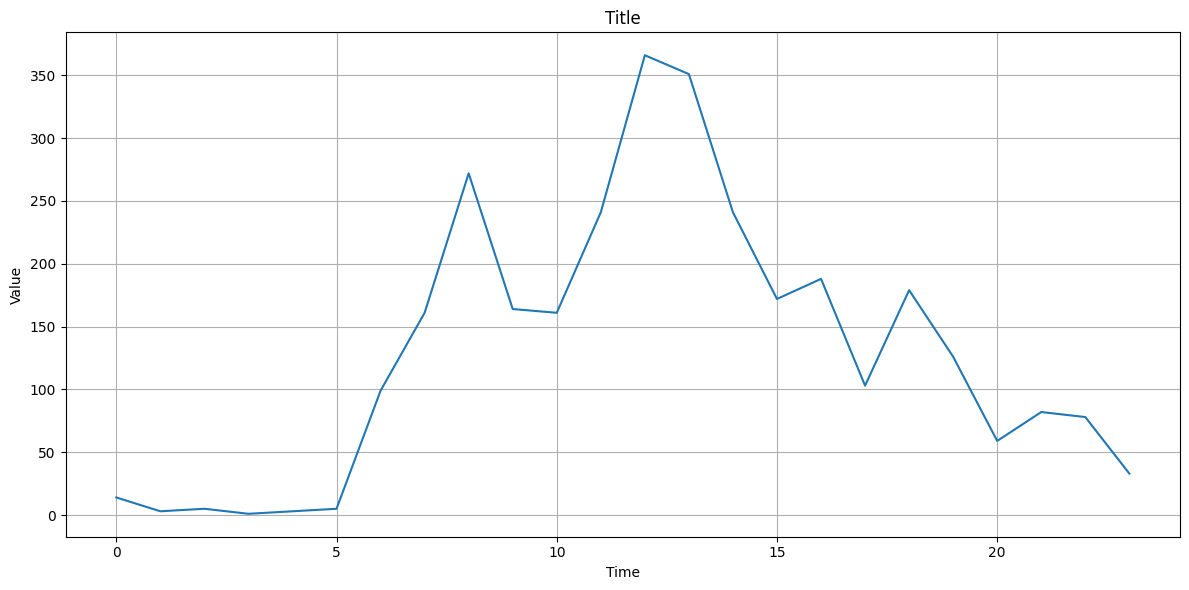

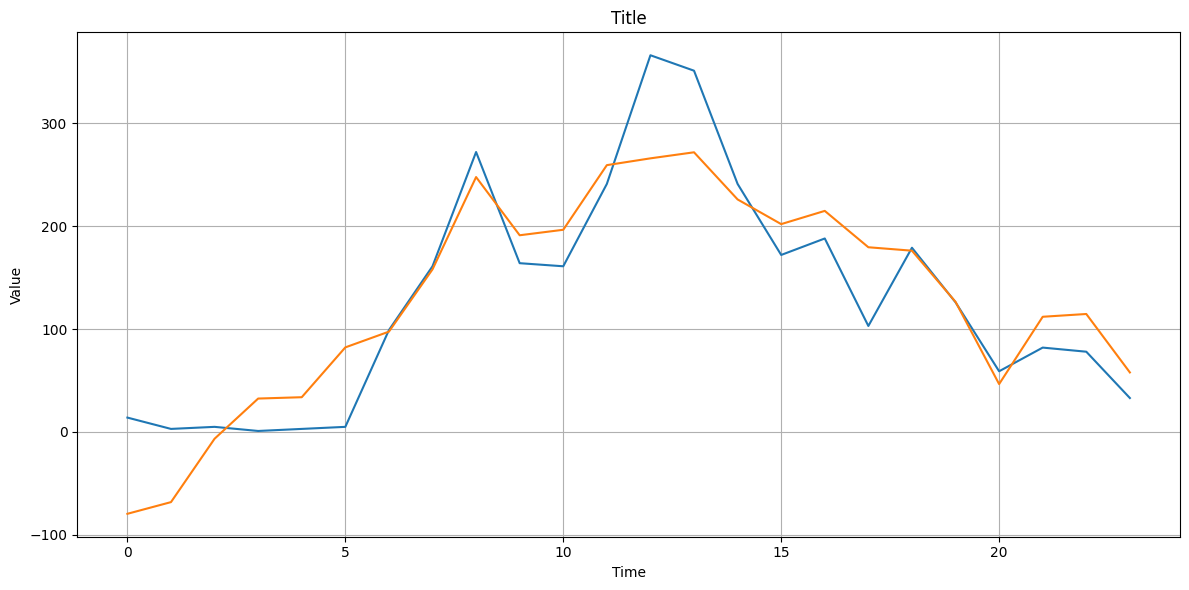

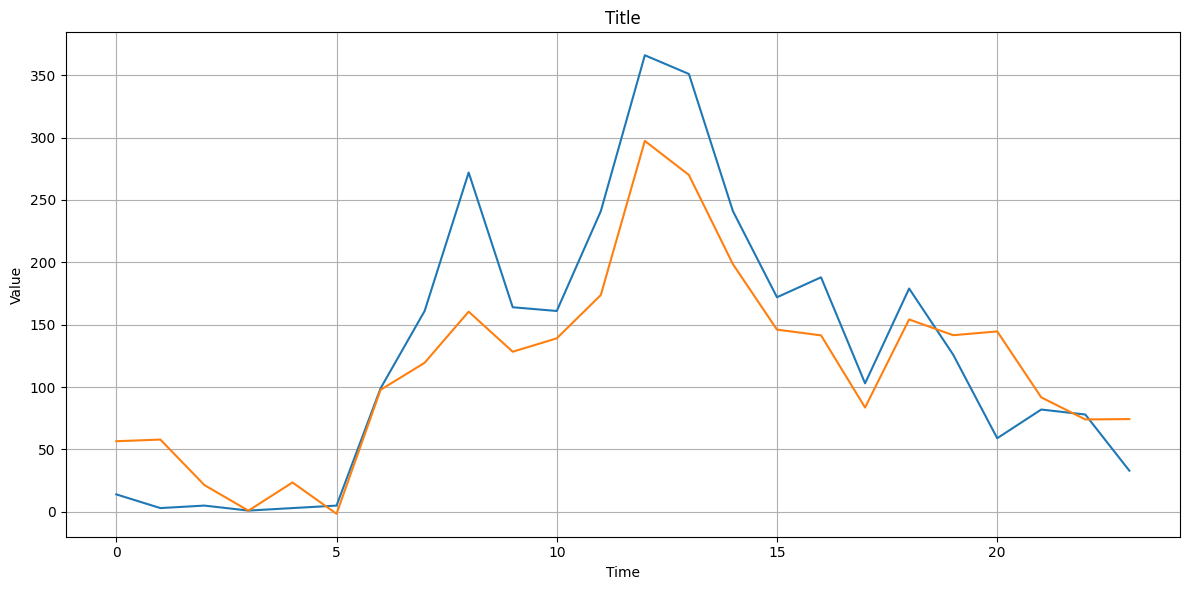

In [24]:
idx = 10
plot_series([item for item in X_train[idx]], show_legend=False)

# plot_series(result[idx]['trend'])
# plot_series(result[idx]['seasonal'])
# plot_series(result[idx]['resid'])

plot_series([X_train[idx,0,:].reshape(-1,1),(np.asarray(result[idx]['trend']) + np.asarray(result[idx]['resid'])).reshape(-1,1)], show_legend=False)
plot_series([X_train[idx,0,:].reshape(-1,1),(np.asarray(result[idx]['trend']) + np.asarray(result[idx]['seasonal'])).reshape(-1,1)], show_legend=False)


In [25]:
def seasonal_strength(seasonal_component, residuals):
    var_resid = np.var(residuals)
    var_seasonal_plus_resid = np.var(seasonal_component + residuals)
    return max(0, 1 - var_resid / var_seasonal_plus_resid)

seasonal_strength(result[idx]['seasonal'], result[idx]['resid'])

0.05788637573450994

In [26]:
# metrics to estimate fast methods
# learnable methods with patterns or just embedding structure

## trend est metric

In [27]:
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.linear_model import LinearRegression

# Example trend data (replace with your trend component)
t = np.arange(100)
trend = 0.1 * t + 0.005 * (t - 50)**2  # Slightly nonlinear trend

# Fit LOWESS (flexible)
lowess_fit = lowess(trend, t, frac=0.3)  # frac = bandwidth (tune as needed)
trend_lowess = lowess_fit[:, 1]

# Fit Linear (strict)
linear_model = LinearRegression().fit(t.reshape(-1, 1), trend)
trend_linear = linear_model.predict(t.reshape(-1, 1))

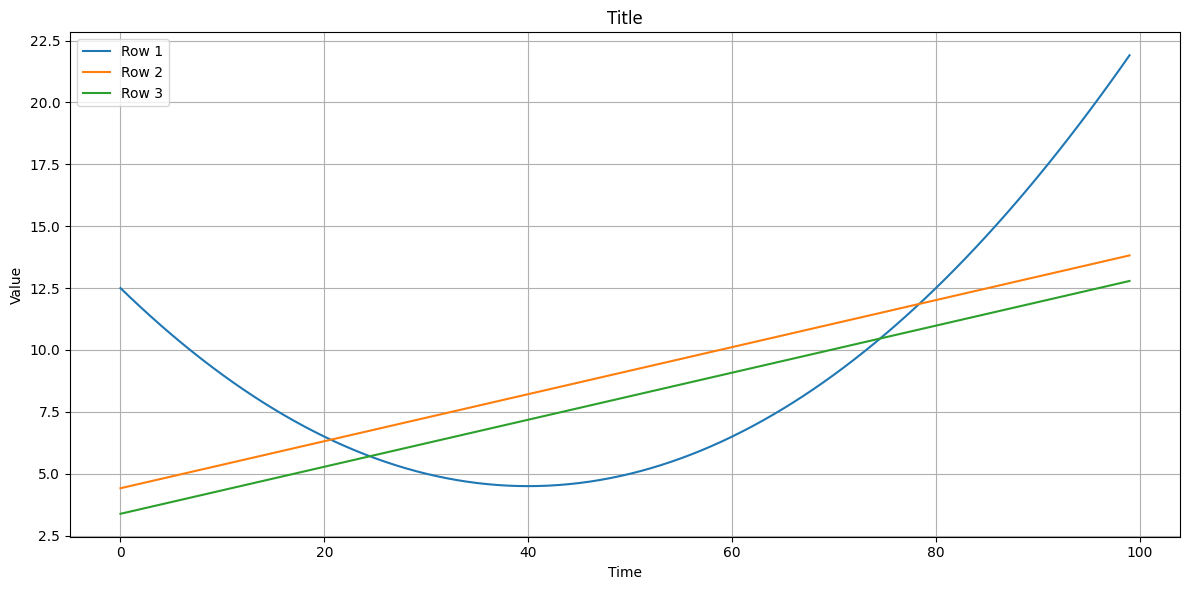

In [28]:
plot_series([
    trend, 
    trend_linear,
    np.linspace(trend[0], trend[-1], trend.shape[0]) - np.mean(trend)
])

## seasonality optuna optimization

In [23]:
import numpy as np
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import acf

def seasonal_strength(seasonal_component, residuals):
    """Maximize seasonal strength (range: 0 to 1)."""
    return max(0, 1 - np.var(residuals) / np.var(seasonal_component + residuals))

def normalized_seasonal_strength(seasonal, residuals):
    var_resid = np.var(residuals)
    var_seasonal = np.var(seasonal)
    return max(0, 1 - var_resid / var_seasonal)

def residual_autocorrelation(residuals, nlags=5):
    """Minimize sum of absolute residual ACF (closer to 0 = better)."""
    acf_values = acf(residuals, nlags=nlags, fft=False)[1:]  # Exclude lag 0
    return np.sum(np.abs(acf_values))

def seasonal_correlation(seasonal_component, seasonal_period):
    """Maximize correlation between seasonal component and ideal signal."""
    t = np.arange(len(seasonal_component))
    ideal_signal = np.sin(2 * np.pi * t / seasonal_period)
    corr, _ = pearsonr(seasonal_component, ideal_signal)
    return corr

In [33]:
from scipy.signal import find_peaks

def validate_period(seasonal_component, candidate_period, tolerance=1):
    """Check if peaks in seasonal component match the candidate period."""
    peaks, _ = find_peaks(seasonal_component)
    if len(peaks) < 2:
        return False  # Not enough peaks to validate
    
    # Calculate intervals between consecutive peaks
    peak_intervals = np.diff(peaks)
    median_interval = np.median(peak_intervals)
    
    # Check if median interval matches candidate period (tolerance)
    return abs(median_interval - candidate_period) <= tolerance

from scipy.signal import periodogram

def spectral_penalty(data, candidate_period):
    freqs, psd = periodogram(data)
    dominant_freq = freqs[np.argmax(psd)]
    expected_freq = 1 / candidate_period
    return np.abs(dominant_freq - expected_freq) * 100  

def objective1(trial):
    np.random.seed(25)
    trend = np.random.randn(100) * 0.1 + np.linspace(0, 10, 100)  # Linear trend + noise
    seasonal = 2 * np.sin(2 * np.pi * np.arange(100) / 12) # Yearly seasonality
    residuals = np.random.randn(100) * 0.3 # White noise
    data = trend + seasonal + residuals
    
    try:
        seasonal_period = trial.suggest_int('seasonal_period', 2, 48)
        model = STL(data, period = seasonal_period)
        result = model.fit()
        seasonal, residuals = result.seasonal, result.resid
        # penalty = np.log(seasonal_period) 
        
        # Penalize if peaks don't match the candidate period
        if not validate_period(seasonal, seasonal_period):
           return 0 
        return seasonal_strength(seasonal, residuals)
    
    except:
        return float('inf')

In [34]:
import optuna 
import logging
# Отключаем информационные сообщения
optuna.logging.set_verbosity(optuna.logging.WARNING)

for _ in range(10):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective1, n_trials=50)

    trial = study.best_trial

    print("Best hyperparameters: {}".format(trial.params))
    print("metric: {}".format(trial.value))

    # optuna.visualization.plot_optimization_history(study)

Best hyperparameters: {'seasonal_period': 12}
metric: 0.9643142979656182
Best hyperparameters: {'seasonal_period': 12}
metric: 0.9643142979656182
Best hyperparameters: {'seasonal_period': 12}
metric: 0.9643142979656182
Best hyperparameters: {'seasonal_period': 12}
metric: 0.9643142979656182
Best hyperparameters: {'seasonal_period': 12}
metric: 0.9643142979656182
Best hyperparameters: {'seasonal_period': 12}
metric: 0.9643142979656182
Best hyperparameters: {'seasonal_period': 12}
metric: 0.9643142979656182
Best hyperparameters: {'seasonal_period': 12}
metric: 0.9643142979656182
Best hyperparameters: {'seasonal_period': 12}
metric: 0.9643142979656182
Best hyperparameters: {'seasonal_period': 12}
metric: 0.9643142979656182


In [ ]:
np.random.seed(25)
trend = np.random.randn(100) * 0.1 + np.linspace(0, 10, 100)  # Linear trend + noise
seasonal = 2 * np.sin(2 * np.pi * np.arange(100) / 12) # Yearly seasonality
residuals = np.random.randn(100) * 0.01 # White noise
data = trend + seasonal + residuals


period = 12
model = STL(data, period = period)
result = model.fit()
seasonal, residuals = result.seasonal, result.resid
print(seasonal_strength(seasonal, residuals))
print(validate_period(seasonal, period))

_ = result.plot()

# residuals are too small for big period

In [ ]:
spectral_penalty(data, 25)

In [26]:
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler

def get_subseqs(data, window_size, stride=1):
    """
    Generate subsequences as a generator (memory efficient for large data).
    
    Args:
        data: list or 1D array of time-series data
        window_size: length of each subsequence
        stride: step size between windows
    
    Yields:
        One subsequence at a time
    """
    for i in range(0, len(data) - window_size + 1, stride):
        yield data[i:i + window_size]

def ts_properties(subseq):
    """Calculate important time-series properties for a subsequence"""
    scaled = StandardScaler().fit_transform(subseq.reshape(-1, 1)).flatten()
    
    return {
        'length': len(subseq),
        'mean': np.mean(subseq),
        'std': np.std(subseq),
        'noisiness': np.std(np.diff(subseq)),
        'stationarity': stats.adfuller(subseq)[1],  # ADF p-value
        'trend_strength': np.corrcoef(np.arange(len(subseq)), subseq)[0, 1],
        'entropy': stats.entropy(np.histogram(scaled, bins=10)[0] + 1e-12)
    }

def sample_subseqs(data, window_size, n_samples, property_weights=None):
    """
    Randomly sample subsequences weighted by time-series properties
    
    Args:
        data: Input time-series
        window_size: Length of subsequences
        n_samples: Number of samples to return
        property_weights: Dict of weights for each property
            (default: {'noisiness': 0.4, 'stationarity': 0.6})
    
    Returns:
        List of sampled subsequences and their properties
    """
    if property_weights is None:
        property_weights = {'noisiness': 0.4, 'stationarity': 0.6}
    
    # Generate all possible subsequences with properties
    subseqs = list(get_subseqs(np.array(data), window_size))
    props = [ts_properties(s) for s in subseqs]
    
    # Calculate composite scores
    scores = np.zeros(len(subseqs))
    for prop, weight in property_weights.items():
        vals = np.array([p[prop] for p in props])
        if prop == 'stationarity':  # Lower p-value = more stationary
            vals = 1 - vals
        scores += weight * (vals - np.min(vals)) / (np.max(vals) - np.min(vals) + 1e-12)
    
    # Sample according to scores
    sample_probs = scores / np.sum(scores)
    sample_idx = np.random.choice(
        len(subseqs), 
        size=min(n_samples, len(subseqs)), 
        p=sample_probs, 
        replace=False
    )
    
    return [(subseqs[i], props[i]) for i in sample_idx]

In [ ]:
import ruptures as rpt

kernel_type = 'rbf'
min_size = 12
jump = 5
pen = 1

# params = {"gamma": 0.001}
params= None

# for idx in range(len(result.keys())):
idx = 2
signal = np.asarray(result[idx]['trend'][0])
algo = rpt.KernelCPD(kernel=kernel_type, min_size=min_size, jump=jump, params=params).fit(signal)
change_points = np.array(algo.predict(pen=pen))
print(change_points)

rpt.display(signal, change_points, change_points)

In [ ]:
# exp with segm for pattern